In [1]:
from metrics.function_error import SquaredError
from models.linear import LeastSquaresModel
from models.zero_model import ZeroModel
from function_classes.linear import LinearRegression

from torch.distributions.normal import Normal
import torch

from torch import nn


from torch import normal

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
m = Normal(torch.zeros((4, 100, 10)), torch.ones((4, 100 ,10))) #batch size, sequence_length, x_dim

error=SquaredError(function_class=LinearRegression(m))

evals=error.evaluate([LeastSquaresModel(), ZeroModel()])

print(evals[0].keys())

print(evals[1])

dict_keys(['accuracy_OLS_driver=None', 'std_OLS_driver=None', 'std_mean_OLS_driver=None', 'max_OLS_driver=None', 'min_OLS_driver=None', 'quantile_OLS_driver=None0.01', 'quantile_OLS_driver=None0.05', 'quantile_OLS_driver=None0.1', 'quantile_OLS_driver=None0.25', 'quantile_OLS_driver=None0.5', 'quantile_OLS_driver=None0.75', 'quantile_OLS_driver=None0.9', 'quantile_OLS_driver=None0.95', 'quantile_OLS_driver=None0.99', 'accuracy_zero_model', 'std_zero_model', 'std_mean_zero_model', 'max_zero_model', 'min_zero_model', 'quantile_zero_model0.01', 'quantile_zero_model0.05', 'quantile_zero_model0.1', 'quantile_zero_model0.25', 'quantile_zero_model0.5', 'quantile_zero_model0.75', 'quantile_zero_model0.9', 'quantile_zero_model0.95', 'quantile_zero_model0.99'])
tensor([[[4.9338e+01, 4.0820e+02, 2.7000e+01, 6.6156e+00, 2.7793e+02,
          5.3644e+01, 4.0295e+01, 1.9296e+01, 2.1590e+02, 8.8639e-04,
          5.0227e-10, 0.0000e+00, 8.1855e-12, 1.4552e-11, 2.7512e-11,
          2.1064e-11, 3.6380

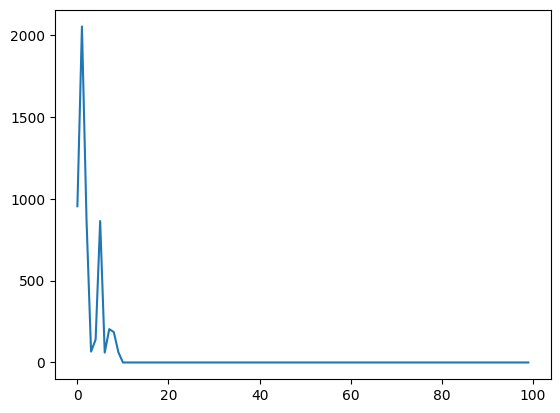

In [7]:
import matplotlib.pyplot as plt

plt.plot(evals[0]['accuracy_OLS_driver=None'])